In [1]:
from codecarbon import EmissionsTracker

# Set up the emissions tracker
tracker = EmissionsTracker()

[codecarbon INFO @ 17:19:10] [setup] RAM Tracking...
[codecarbon INFO @ 17:19:10] [setup] GPU Tracking...
[codecarbon INFO @ 17:19:10] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:19:10] [setup] CPU Tracking...
[codecarbon WARNING @ 17:19:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 17:19:11] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 17:19:11] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 17:19:11] >>> Tracker's metadata:
[codecarbon INFO @ 17:19:11]   Platform system: Windows-10-10.0.22000-SP0
[codecarbon INFO @ 17:19:11]   Python version: 3.8.5
[codecarbon INFO @ 17:19:11]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 17:19:11]   Available RAM : 15.692 GB
[codecarbon INFO @ 17:19:11]   CPU count: 20
[codecarbon INFO @ 17:19:11]   CPU model: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 17:19:11] 

In [2]:
# Start tracking
tracker.start()

In [3]:
import pandas as pd

# Load the data
file_path = '../data/Water Level - Santa Barbara - v2.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe and its summary
data.head(), data.describe(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10944 entries, 0 to 10943
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10944 non-null  object 
 1   Time (GMT)      10944 non-null  object 
 2   Predicted (ft)  10944 non-null  float64
 3   Verified (ft)   10944 non-null  float64
dtypes: float64(2), object(2)
memory usage: 342.1+ KB


(       Date Time (GMT)  Predicted (ft)  Verified (ft)
 0  1/1/2023       0:00           2.623           3.14
 1  1/1/2023       1:00           2.964           3.45
 2  1/1/2023       2:00           3.021           3.74
 3  1/1/2023       3:00           2.822           3.44
 4  1/1/2023       4:00           2.450           3.08,
        Predicted (ft)  Verified (ft)
 count    10944.000000   10944.000000
 mean         2.748448       3.017254
 std          1.676776       1.688751
 min         -2.025000      -2.040000
 25%          1.599750       1.860000
 50%          2.879500       3.150000
 75%          3.883250       4.170000
 max          7.129000       7.560000,
 None)

In [4]:
# Combine 'Date' and 'Time (GMT)' into a single datetime column
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time (GMT)'])

# Set DateTime as the index
data.set_index('DateTime', inplace=True)

# Drop original 'Date' and 'Time (GMT)' columns
data.drop(['Date', 'Time (GMT)'], axis=1, inplace=True)

# Display the updated DataFrame
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10944 entries, 2023-01-01 00:00:00 to 2024-03-31 23:00:00
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Predicted (ft)  10944 non-null  float64
 1   Verified (ft)   10944 non-null  float64
dtypes: float64(2)
memory usage: 256.5 KB


(                     Predicted (ft)  Verified (ft)
 DateTime                                          
 2023-01-01 00:00:00           2.623           3.14
 2023-01-01 01:00:00           2.964           3.45
 2023-01-01 02:00:00           3.021           3.74
 2023-01-01 03:00:00           2.822           3.44
 2023-01-01 04:00:00           2.450           3.08,
 None)

In [5]:
# Creating time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Display the new DataFrame with added features
data.head()


,Predicted (ft),Verified (ft),hour,day_of_week,month
DateTime,,,,,
2023-01-01 00:00:00,2.623,3.14,0,6,1
2023-01-01 01:00:00,2.964,3.45,1,6,1
2023-01-01 02:00:00,3.021,3.74,2,6,1
2023-01-01 03:00:00,2.822,3.44,3,6,1
2023-01-01 04:00:00,2.450,3.08,4,6,1


In [6]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = data[['hour', 'day_of_week', 'month', 'Predicted (ft)']]  # Including predicted water levels as a feature
y = data['Verified (ft)']

# Train-test split: Using data from March 2024 as test set
train = data.loc[:'2024-02-29']
test = data.loc['2024-03-01':]

X_train = train[['hour', 'day_of_week', 'month', 'Predicted (ft)']]
y_train = train['Verified (ft)']
X_test = test[['hour', 'day_of_week', 'month', 'Predicted (ft)']]
y_test = test['Verified (ft)']

# Checking the shape of the train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((10200, 4), (744, 4), (10200,), (744,))

In [7]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Calculate RMSE
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)

rf_rmse


0.22029725291448923

In [8]:
# Calculate the mean squared error for the model
mse_rf = mean_squared_error(y_test, rf_predictions)
mse_rf


0.04853087964167043

In [9]:
# Initialize the Gradient Boosting Regressor
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model
gbm_model.fit(X_train, y_train)

# Predict on the test set
gbm_predictions = gbm_model.predict(X_test)

# Calculate RMSE
gbm_rmse = mean_squared_error(y_test, gbm_predictions, squared=False)

gbm_rmse


0.20171425833344947

In [10]:
# Calculate the mean squared error for the GBM model
mse_gbm = mean_squared_error(y_test, gbm_predictions)
mse_gbm


0.04068864201501359

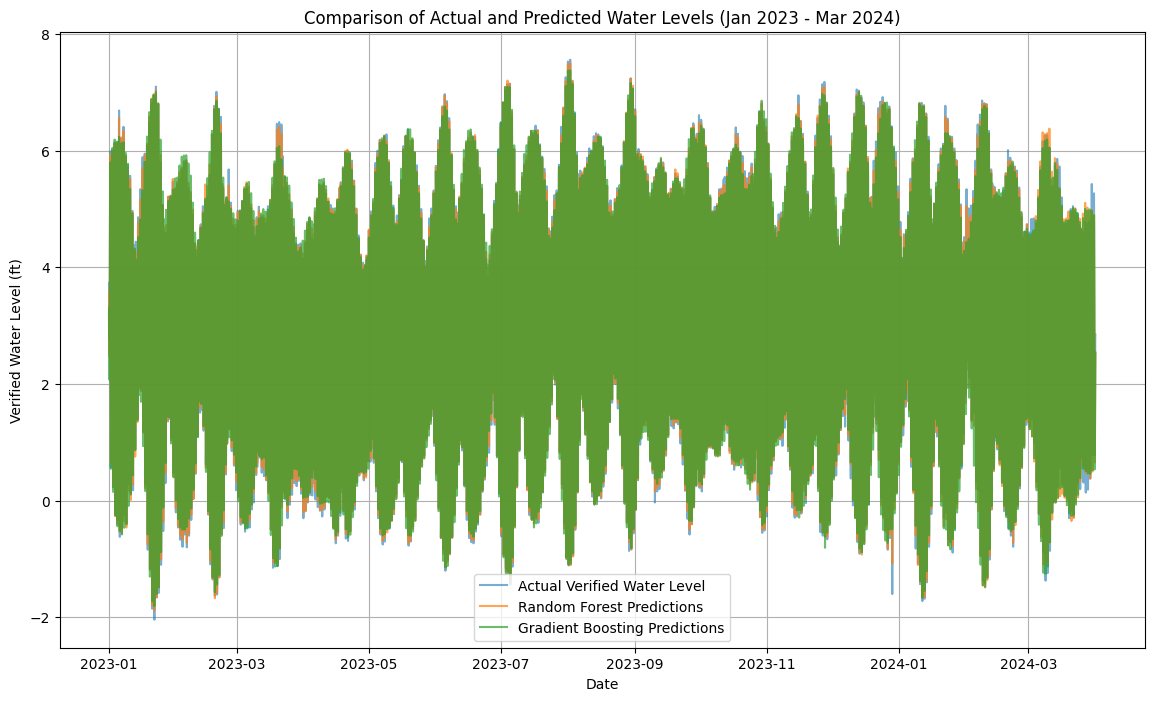

In [11]:
import matplotlib.pyplot as plt

# Extract features for prediction for the entire period from January 1, 2023, to March 31, 2024
features_full_period = data[['hour', 'day_of_week', 'month', 'Predicted (ft)']]

# Make predictions with both models for the full period
rf_full_predictions = rf_model.predict(features_full_period)
gbm_full_predictions = gbm_model.predict(features_full_period)

# Adding predictions back to the original data for plotting
data['RF Predictions (ft)'] = rf_full_predictions
data['GBM Predictions (ft)'] = gbm_full_predictions

# Sorting the index to ensure correct plotting order for the entire dataset
actual_values_full_sorted = data['Verified (ft)'].sort_index()
rf_predictions_full_sorted = data['RF Predictions (ft)'].sort_index()
gbm_predictions_full_sorted = data['GBM Predictions (ft)'].sort_index()

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(actual_values_full_sorted, label='Actual Verified Water Level', alpha=0.6)
plt.plot(rf_predictions_full_sorted, label='Random Forest Predictions', alpha=0.7)
plt.plot(gbm_predictions_full_sorted, label='Gradient Boosting Predictions', alpha=0.7)
plt.title('Comparison of Actual and Predicted Water Levels (Jan 2023 - Mar 2024)')
plt.xlabel('Date')
plt.ylabel('Verified Water Level (ft)')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Load the provided ground truth data for April 1, 2024
future_data_path = '../data/future data - Santa Barbara.csv'
future_data = pd.read_csv(future_data_path)

# Display the first few rows of the dataframe and its summary
future_data.head(), future_data.describe(), future_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            24 non-null     object 
 1   Time (GMT)      24 non-null     object 
 2   Predicted (ft)  24 non-null     float64
 3   Verified (ft)   24 non-null     float64
dtypes: float64(2), object(2)
memory usage: 896.0+ bytes


(       Date Time (GMT)  Predicted (ft)  Verified (ft)
 0  4/1/2024       0:00           2.581           2.83
 1  4/1/2024       1:00           2.674           3.01
 2  4/1/2024       2:00           2.780           3.05
 3  4/1/2024       3:00           2.943           3.29
 4  4/1/2024       4:00           3.196           3.41,
        Predicted (ft)  Verified (ft)
 count       24.000000      24.000000
 mean         2.543875       2.737917
 std          1.469074       1.527763
 min          0.172000       0.270000
 25%          1.320500       1.465000
 50%          2.727000       3.000000
 75%          3.712500       3.927500
 max          4.641000       4.880000,
 None)

In [13]:
# Combine 'Date' and 'Time (GMT)' into a single datetime column
future_data['DateTime'] = pd.to_datetime(future_data['Date'] + ' ' + future_data['Time (GMT)'])

# Create time-based features
future_data['hour'] = future_data['DateTime'].dt.hour
future_data['day_of_week'] = future_data['DateTime'].dt.dayofweek
future_data['month'] = future_data['DateTime'].dt.month

# Set DateTime as the index
future_data.set_index('DateTime', inplace=True)

# Drop original 'Date' and 'Time (GMT)' columns
future_data.drop(['Date', 'Time (GMT)'], axis=1, inplace=True)

# Display the updated DataFrame with added features
future_data.head()


,Predicted (ft),Verified (ft),hour,day_of_week,month
DateTime,,,,,
2024-04-01 00:00:00,2.581,2.83,0,0,4
2024-04-01 01:00:00,2.674,3.01,1,0,4
2024-04-01 02:00:00,2.780,3.05,2,0,4
2024-04-01 03:00:00,2.943,3.29,3,0,4
2024-04-01 04:00:00,3.196,3.41,4,0,4


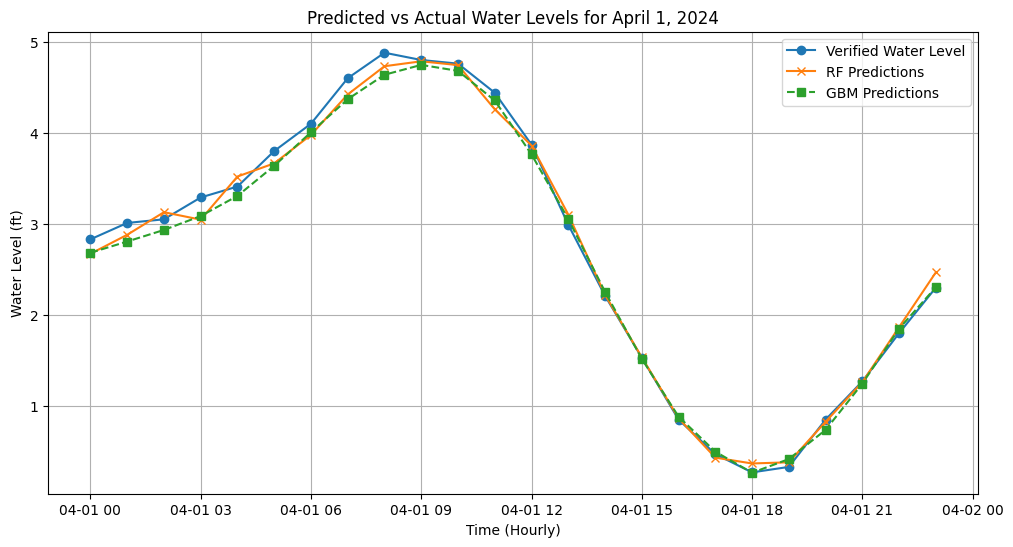

In [14]:
# Extract features for prediction
features_future = future_data[['hour', 'day_of_week', 'month', 'Predicted (ft)']]

# Make predictions with both models
rf_future_predictions = rf_model.predict(features_future)
gbm_future_predictions = gbm_model.predict(features_future)

# Add predictions to the dataframe for plotting
future_data['RF Predictions (ft)'] = rf_future_predictions
future_data['GBM Predictions (ft)'] = gbm_future_predictions

# Plotting the predictions and the actual verified water levels
plt.figure(figsize=(12, 6))
plt.plot(future_data.index, future_data['Verified (ft)'], label='Verified Water Level', marker='o')
plt.plot(future_data.index, future_data['RF Predictions (ft)'], label='RF Predictions', marker='x')
plt.plot(future_data.index, future_data['GBM Predictions (ft)'], label='GBM Predictions', linestyle='--', marker='s')
plt.title('Predicted vs Actual Water Levels for April 1, 2024')
plt.xlabel('Time (Hourly)')
plt.ylabel('Water Level (ft)')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Calculate RMSE for Random Forest predictions on the future data
rf_future_rmse = mean_squared_error(future_data['Verified (ft)'], future_data['RF Predictions (ft)'], squared=False)

# Calculate RMSE for Gradient Boosting Machine predictions on the future data
gbm_future_rmse = mean_squared_error(future_data['Verified (ft)'], future_data['GBM Predictions (ft)'], squared=False)

rf_future_rmse, gbm_future_rmse


(0.11182707260170328, 0.11817464785255043)

In [16]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate Mean Absolute Error (MAE) for both models
rf_mae = mean_absolute_error(future_data['Verified (ft)'], future_data['RF Predictions (ft)'])
gbm_mae = mean_absolute_error(future_data['Verified (ft)'], future_data['GBM Predictions (ft)'])

# Calculate R-squared (R^2) for both models
rf_r2 = r2_score(future_data['Verified (ft)'], future_data['RF Predictions (ft)'])
gbm_r2 = r2_score(future_data['Verified (ft)'], future_data['GBM Predictions (ft)'])

# RMSE has been previously calculated, outputting all metrics
rf_future_rmse, gbm_future_rmse, rf_mae, gbm_mae, rf_r2, gbm_r2


(0.11182707260170328,
 0.11817464785255043,
 0.08838333333333308,
 0.09532655317944567,
 0.9944093130596324,
 0.9937566181818611)

**Random Forest Model**
- RMSE: 0.112
- MAE: 0.088
- R-squared: 0.994

**Gradient Boosting Machine Model**
- RMSE: 0.118
- MAE: 0.095
- R-squared: 0.994

In [17]:
# Stop tracking and get emissions data
emissions = tracker.stop()
print(f"Estimated CO2 emissions for the computation: {emissions} kg")

[codecarbon INFO @ 17:19:20] Energy consumed for RAM : 0.000008 kWh. RAM Power : 5.884547710418702 W
[codecarbon INFO @ 17:19:20] Energy consumed for all GPUs : 0.000039 kWh. Total GPU Power : 27.21778379103047 W
[codecarbon INFO @ 17:19:20] Energy consumed for all CPUs : 0.000061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:20] 0.000108 kWh of electricity used since the beginning.


Estimated CO2 emissions for the computation: 3.987399064982565e-05 kg
